In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import TargetEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [121]:
flight_df = pd.read_csv("dataset_flights.csv")
flight_df= flight_df.drop('ID', axis=1)
print(flight_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           48507 non-null  object 
 1   flight            48507 non-null  object 
 2   source_city       48502 non-null  object 
 3   departure_time    48526 non-null  object 
 4   stops             48549 non-null  object 
 5   arrival_time      48554 non-null  object 
 6   destination_city  48511 non-null  object 
 7   class             48516 non-null  object 
 8   duration          48515 non-null  float64
 9   days_left         48503 non-null  float64
 10  price             48524 non-null  float64
dtypes: float64(3), object(8)
memory usage: 4.2+ MB
None


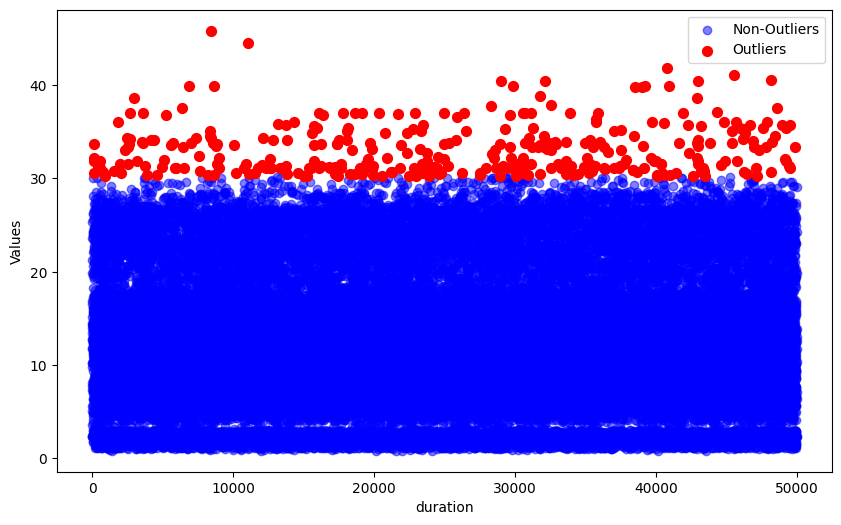

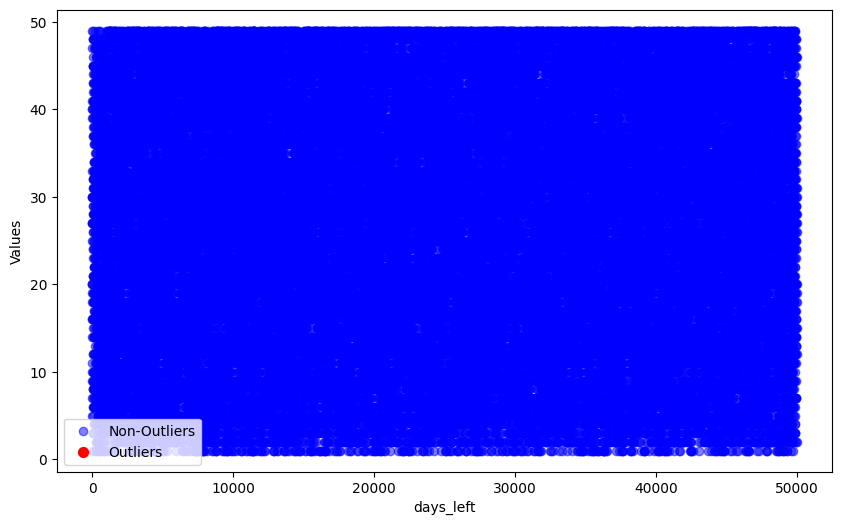

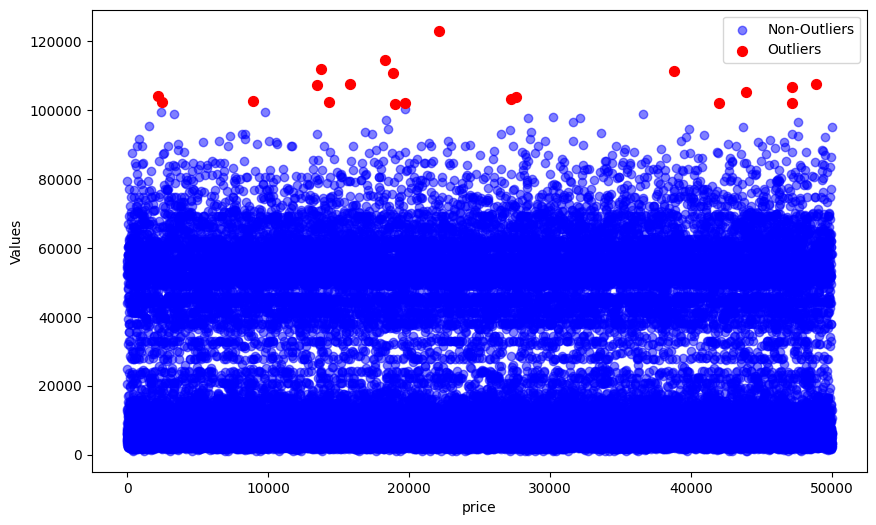

In [122]:
def detectOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outlier_columns = ['duration', 'days_left', 'price']
for column in outlier_columns:
    outliers = detectOutliers(flight_df, column)
    flight_df = flight_df.drop(outliers.index)
    
    plt.figure(figsize=(10,6))

    plt.scatter(flight_df.index, flight_df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)

    plt.xlabel(column)
    plt.ylabel("Values")
    plt.legend()
    plt.show()

In [123]:
nullValues = flight_df.isnull().sum()
duplicates = flight_df.duplicated().sum()
samples = flight_df.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)

airline             1479
flight              1482
source_city         1490
departure_time      1465
stops               1440
arrival_time        1435
destination_city    1484
class               1470
duration            1485
days_left           1487
price               1470
dtype: int64
Null values total:  16187
Duplicates: 36
Samples:  49646


In [124]:
#odstranenie stlpcov v ktorych je vela null hodnot, duplicit a null hodnot
flight_df_cleaned = flight_df.dropna()
flight_df_cleaned = flight_df_cleaned.drop_duplicates()

nullValues = flight_df_cleaned.isnull().sum()
duplicates = flight_df_cleaned.duplicated().sum()
samples = flight_df_cleaned.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)
print("========")
print("Unique values: ")
print(flight_df_cleaned.nunique())

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Null values total:  0
Duplicates: 0
Samples:  35596
Unique values: 
airline                6
flight              1396
source_city            6
departure_time         6
stops                  3
arrival_time           6
destination_city       6
class                  2
duration             355
days_left             49
price               5567
dtype: int64


In [125]:
flight_df_cleaned.reset_index(drop=True, inplace=True)
one_hot_encoded_columns = ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']
flight_df_encoded = flight_df_cleaned.copy()
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(flight_df_encoded[column])
    flight_df_encoded= pd.concat([flight_df_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

label_encoder = LabelEncoder()
flight_df_encoded['stops'] = flight_df_encoded['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})

targetEncoder = TargetEncoder(smooth=1) 
flight_df_encoded['flight'] = targetEncoder.fit_transform(flight_df_cleaned[['flight']], flight_df_cleaned[['price']])
#flight_df_end['airline'] = targetEncoder.fit_transform(flight_df_cleaned[['airline']], flight_df_cleaned[['price']])

/home/des/suns/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [126]:
flight_df_encoded.reset_index(drop=True, inplace=True)
X = flight_df_encoded.drop('price', axis=1)
Y = flight_df_encoded['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)


X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((24917, 36), (24917,), (10679, 36), (10679,))

In [127]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

R2 score test data:  0.9621195369986373
RMSE test data:  4393.975883044134
R2 score train data:  0.9999933206656485
RMSE test data:  58.723973270904594


/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

R2 score test data:  0.9794063579393437
MSE test data:  10496227.11184242
R2 score train data:  0.9972528279535645
MSE test data:  1418350.4134210818


In [133]:
model = SVR(kernel='rbf', C=1000)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

R2 score test data:  0.9472386966148176
RMSE test data:  5185.7047614811845
R2 score train data:  0.9517284095115838
RMSE test data:  4992.2306773157425


/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
